In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1
**ansiedad** : 2



In [ ]:
num_docs = 15000

In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /Data: A D C/train.csv'
#data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
data_train = data.iloc[:num_docs, :]
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].astype(str)
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     10062 non-null  object 
 1   TWEET_ID    10051 non-null  float64
 2   TWEET_TEXT  15000 non-null  object 
 3   trastorno   15000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 468.9+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,RT @FraRocanroleras: Te estás destruyendo y lo...,1
1,6,2.147484e+09,No sé cómo estar sin ti pero tampoco sé cómo e...,0
2,NaN,NaN,Me pregunto por qué últimamente no me siento ...,2
3,NaN,NaN,Mi ansiedad en torno a toda esta enfermedad s...,2
4,NaN,NaN,Esto ha estado en mi mente bastante durante lo...,2
5,NaN,NaN,¿Necesitas algunas ideas? Este canal es maravi...,2
6,31,2.147484e+09,"Intenté decir algo pero no pude,sólo quedé con...",0
7,27,2.147484e+09,tumblrbot ha preguntado: ROBOTS OR DINOSAURS? ...,1
8,49,2.147484e+09,El smirnoff es la bebida mas traicionera que e...,1
9,36,2.147484e+09,¿Por qué mis primas son delgadas y tan hermosa...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

*Limpiar texto*

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_en
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string

#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
#data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruyendo único haces reírte,1
1,6,2.147484e+09,cómo tampoco cómo contigo,0
2,NaN,NaN,pregunto últimamente siento tranquilo punto au...,2
3,NaN,NaN,ansiedad torno toda enfermedad disparado,2
4,NaN,NaN,mente bastante últimos meses compañero cuarto ...,2
5,NaN,NaN,ideas canal maravilloso aquí historias siguen ...,2
6,31,2.147484e+09,intenté decir pudesólo quedé nudo garganta lág...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera existe chabon ...,1
9,36,2.147484e+09,primas delgadas tan hermosas vidas,0


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 818


In [ ]:
# Eliminar filas con valores nulos o vacíos en la columna 'TWEET_TEXT'
data_train.dropna(subset=['TWEET_TEXT'], inplace=True)

# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación
empty_count_after = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos después de la eliminación
print("Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación:", empty_count_after)

# También puedes reindexar el DataFrame después de eliminar las filas
data_train.reset_index(drop=True, inplace=True)


Número de elementos vacíos en la columna 'TWEET_TEXT' después de la eliminación: 818


In [ ]:
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corregir_palabras_largas)
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corrector_ortografico)

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USER_ID     10062 non-null  object 
 1   TWEET_ID    10051 non-null  float64
 2   TWEET_TEXT  15000 non-null  object 
 3   trastorno   15000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 468.9+ KB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,47,2.147484e+09,destruyendo único haces reírte,1
1,6,2.147484e+09,cómo tampoco cómo contigo,0
2,NaN,NaN,pregunto últimamente siento tranquilo punto au...,2
3,NaN,NaN,ansiedad torno toda enfermedad disparado,2
4,NaN,NaN,mente bastante últimos meses compañero cuarto ...,2
5,NaN,NaN,ideas canal maravilloso aquí historias siguen ...,2
6,31,2.147484e+09,intenté decir pudesólo quedé nudo garganta lág...,0
7,27,2.147484e+09,tumblrbot preguntado robots dinosaurs,1
8,49,2.147484e+09,smirnoff bebida mas traicionera existe chabon ...,1
9,36,2.147484e+09,primas delgadas tan hermosas vidas,0


# **LIWC**

In [ ]:
!pip install liwc
import liwc

In [ ]:
liwcPath= r'/content/drive/MyDrive/Experimentación Python Tesis /Diccionarios español/Spanish_LIWC2007_Dictionary.dic'
parse, category_names = liwc.load_token_parser(liwcPath)
print(f'Categorias del diccionario: {category_names}')

Categorias del diccionario: ['Funct', 'TotPron', 'PronPer', 'Yo', 'Nosotro', 'TuUtd', 'ElElla', 'Ellos', 'PronImp', 'Articulo', 'Verbos', 'VerbAux', 'Pasado', 'Present', 'Futuro', 'Adverb', 'Prepos', 'Conjunc', 'Negacio', 'Cuantif', 'Numeros', 'Maldec', 'verbYO', 'verbTU', 'verbNOS', 'verbosEL', 'verbELLOS', 'Subjuntiv', 'VosUtds', 'formal', 'informal', 'verbVos', 'Social', 'Familia', 'Amigos', 'Humanos', 'Afect', 'EmoPos', 'EmoNeg', 'Ansiedad', 'Enfado', 'Triste', 'MecCog', 'Insight', 'Causa', 'Discrep', 'Tentat', 'Certeza', 'Inhib', 'Incl', 'Excl', 'Percept', 'Ver', 'Oir', 'Sentir', 'Biolog', 'Cuerpo', 'Salud', 'Sexual', 'Ingerir', 'Relativ', 'Movim', 'Espacio', 'Tiempo', 'Trabajo', 'Logro', 'Placer', 'Hogar', 'Dinero', 'Relig', 'Muerte', 'Asentir', 'NoFluen', 'Relleno']


In [ ]:
corpus = []
words = []

for i in range(0,len(data_train)):
    review = re.sub('[^a-zA-Z0-9]',' ',data_train['TWEET_TEXT'][i])
    review = review.lower()
    review = review.split()

    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)


# Representación de los datos mediante una matriz TF-IDF



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear una instancia de CountVectorizer
count_vect = CountVectorizer()

# Aplicar CountVectorizer al corpus
count_train = count_vect.fit_transform(corpus)

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es: ", len(count_vect.vocabulary_))

X = count_train  # Matriz de conteo
y = data_train['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

features = count_vect.get_feature_names_out()

# Crear un DataFrame con la matriz de conteo
df_count = pd.DataFrame(count_train.toarray(), columns=features)
df_count


El tamaño del vocabulario es:  72


,adverb,afect,amigos,ansiedad,articulo,asentir,biolog,causa,certeza,conjunc,...,ver,verbaux,verbellos,verbnos,verbos,verbosel,verbtu,verbyo,vosutds,yo
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,2,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,1,0,0,0,0,0,1,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,11,1,0,0,0,5,1,2,0,...,1,1,0,0,14,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,2,0,0,0,1,0,1,0,0,...,1,0,0,0,2,0,0,0,0,0
14996,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0
14997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,1,0,0,0
14998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Entrenamiento y validación del modelo

In [ ]:
from sklearn.model_selection import train_test_split

# Convertir la matriz TF-IDF a una matriz densa de Numpy
X = X.toarray()

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
# Verificar las dimensiones de los conjuntos de entrenamiento y validación
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (11250, 72)
Dimensiones de X_val: (3750, 72)
Dimensiones de y_train: (11250,)
Dimensiones de y_val: (3750,)


# Aprendizaje del modelo: Maquina de Soporte Vectorial

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Suponiendo que ya tienes tus datos de entrenamiento y validación: X_train, X_val, y_train, y_val

# Crear un modelo SVM para clasificación multiclase con kernel polinómico
svm_model_p = SVC(kernel='poly', C=10000,  degree=4, max_iter=50000,  probability=False,  gamma='scale', coef0=0.5)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcular las métricas en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Calcular y mostrar métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Imprimir las métricas en el conjunto de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print("Exactitud (entrenamiento): {:.2%}".format(accuracy_train))
print("Precisión (entrenamiento): {:.2%}".format(precision_train))
print("Recall (entrenamiento): {:.2%}".format(recall_train))
print("F1-score (entrenamiento): {:.2%}".format(f1_train))
print('--'*50)
# Imprimir las métricas en el conjunto de validación
print("Exactitud en el conjunto de validación: {:.2%}".format(accuracy))
print("Precisión en el conjunto de validación: {:.2%}".format(precision))
print("Recall en el conjunto de validación: {:.2%}".format(recall))
print("F1-score en el conjunto de validación: {:.2%}".format(f1))



Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 75.51%
Precisión (entrenamiento): 77.38%
Recall (entrenamiento): 75.51%
F1-score (entrenamiento): 75.24%
----------------------------------------------------------------------------------------------------
Exactitud en el conjunto de validación: 50.45%
Precisión en el conjunto de validación: 50.01%
Recall en el conjunto de validación: 50.45%
F1-score en el conjunto de validación: 49.73%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model_p.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[330 756 155]
 [382 746 184]
 [207 174 816]] 



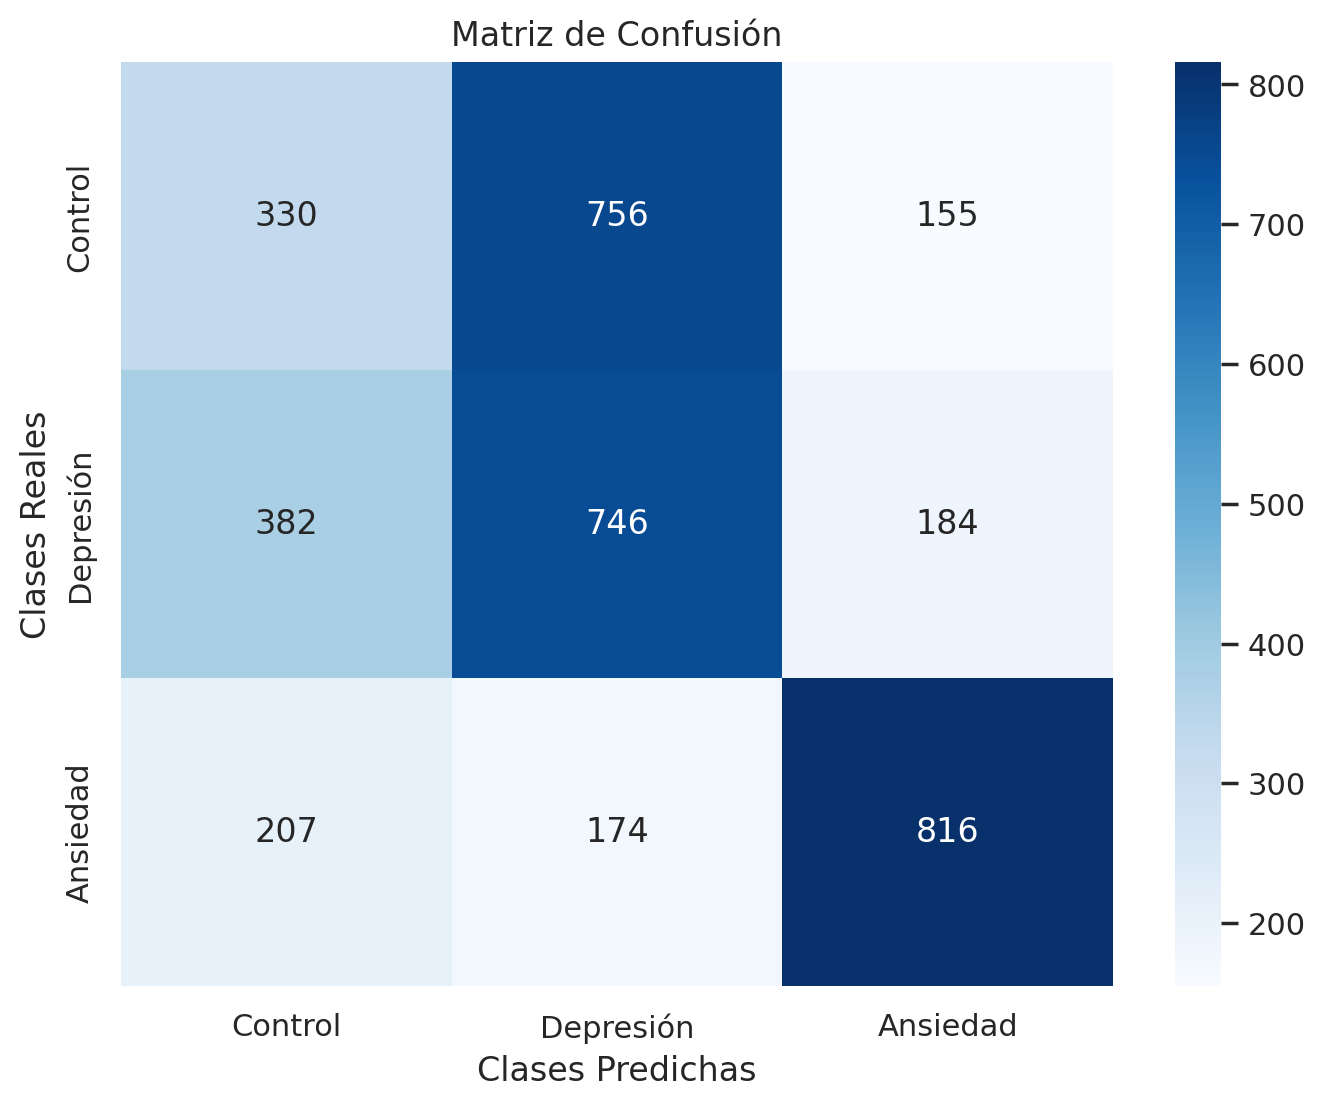

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización
# Convertir las etiquetas en codificación one-hot
num_classes = 3  # Número de clases
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)



# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización


# Agregar una capa de salida con el número de clases en tu clasificación multiclase
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy()])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=100, validation_data=(X_val, y_val_one_hot))

y_val_pred = model.predict(X_val)

y_val_pred_class = y_val_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_val_true_class = y_val_one_hot.argmax(axis=1)  # Usar y_val_one_hot en lugar de y_val si está codificado en one-hot

accuracy = accuracy_score(y_val_true_class, y_val_pred_class)
precision = precision_score(y_val_true_class, y_val_pred_class, average='macro')
recall = recall_score(y_val_true_class, y_val_pred_class, average='macro')
f1 = f1_score(y_val_true_class, y_val_pred_class, average='macro')

y_train_pred = model.predict(X_train)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred_class = y_train_pred.argmax(axis=1)  # Obtener la clase con la mayor probabilidad
y_train_true_class = y_train_one_hot.argmax(axis=1)  # Usar y_train_one_hot en lugar de y_train si está codificado en one-hot

accuracy_train = accuracy_score(y_train_true_class, y_train_pred_class)
precision_train = precision_score(y_train_true_class, y_train_pred_class, average='macro')
recall_train = recall_score(y_train_true_class, y_train_pred_class, average='macro')
f1_train = f1_score(y_train_true_class, y_train_pred_class, average='macro')

Epoch 1/50
113/113 [==============================] - 2s 9ms/step - loss: 0.9080 - categorical_accuracy: 0.5156 - val_loss: 0.8432 - val_categorical_accuracy: 0.5509
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 0.8388 - categorical_accuracy: 0.5511 - val_loss: 0.8282 - val_categorical_accuracy: 0.5517
Epoch 3/50
113/113 [==============================] - 1s 7ms/step - loss: 0.8177 - categorical_accuracy: 0.5675 - val_loss: 0.8187 - val_categorical_accuracy: 0.5536
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 0.7970 - categorical_accuracy: 0.5829 - val_loss: 0.8188 - val_categorical_accuracy: 0.5512
Epoch 5/50
113/113 [==============================] - 1s 8ms/step - loss: 0.7741 - categorical_accuracy: 0.5891 - val_loss: 0.8167 - val_categorical_accuracy: 0.5557
Epoch 6/50
113/113 [==============================] - 1s 7ms/step - loss: 0.7572 - categorical_accuracy: 0.6064 - val_loss: 0.8279 - val_categorical_accuracy: 0.5597
Epoc

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 88.0%
Precisión (entrenamiento): 89.0%
Recall (entrenamiento): 88.0%
F1-score (entrenamiento): 88.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 52.0%
Precisión en el conjunto de validación: 52.0%
Recall en el conjunto de validación: 52.0%
F1-score en el conjunto de validación: 52.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_true_class, y_train_pred_class)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[2981  745   24]
 [ 385 3389   36]
 [  39   81 3570]]


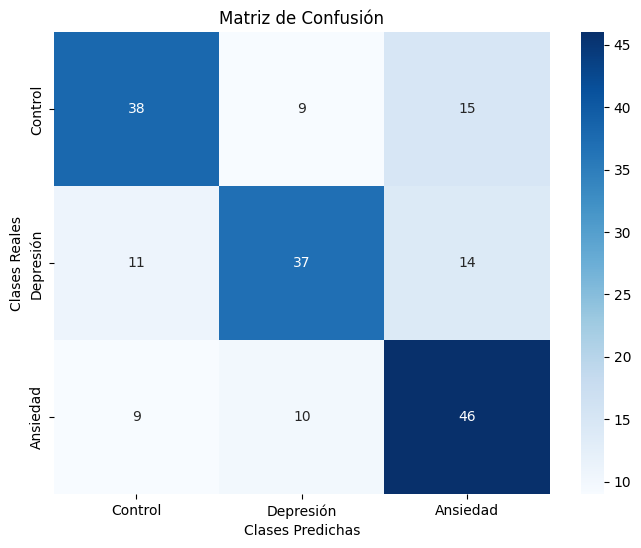

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()

#Modelo Bosque Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(
    n_estimators=500,  # Número de árboles
    max_depth=50,  # Profundidad máxima de los árboles
    random_state=42,  # Semilla aleatoria para reproducibilidad
    n_jobs=-1  # Utilizar todos los núcleos de la CPU para procesamiento en paralelo
)


# Entrena el modelo con los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula e imprime la precisión del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Precisión (Validación): {:.2f}".format(accuracy))

# Calcula e imprime la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precisión (Validación): {:.2f}".format(precision))

# Calcula e imprime la exhaustividad del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Exhaustividad (Validación): {:.2f}".format(recall))

# Calcula e imprime la puntuación F1 del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("Puntuación F1 (Validación): {:.2f}".format(f1))

# Calcula e imprime métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')

print("\nMétricas en el conjunto de entrenamiento:")
print("Precisión: {:.2f}".format(precision_train))
print("Exhaustividad: {:.2f}".format(recall_train))
print("Puntuación F1: {:.2f}".format(f1_train))

Precisión (Validación): 0.54
Precisión (Validación): 0.53
Exhaustividad (Validación): 0.54
Puntuación F1 (Validación): 0.53

Métricas en el conjunto de entrenamiento:
Precisión: 0.90
Exhaustividad: 0.89
Puntuación F1: 0.89


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 99.47%
Precisión  entrenamiento: 99.48%
Recall  entrenamiento: 99.47%
Puntuación F1  entrenamiento: 99.47%


Accuracy  validación: 35.80%
Precisión  validación: 67.77%
Recall  validación: 35.80%
Puntuación F1 validación: 24.35%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = random_forest_model.predict(X_val)

#
cm = confusion_matrix(y_val, y_pred)


#
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)
print("Matriz de confusión: \n\n", cm, "\n")

Matriz de confusión: 

 [[ 2  1 25]
 [ 0  2 26]
 [ 0  0 25]] 



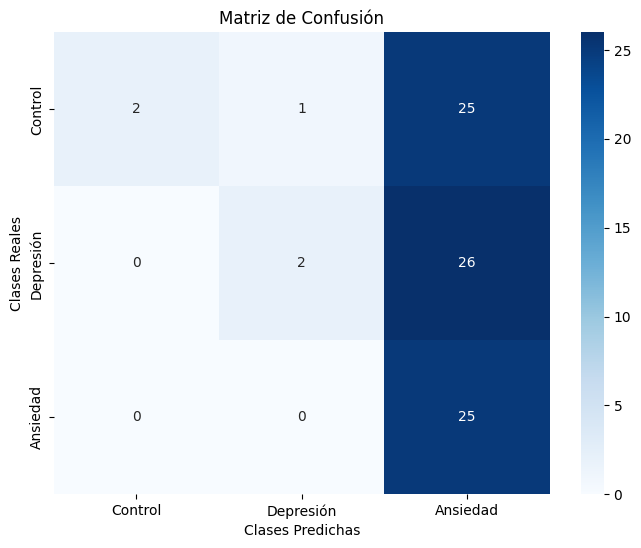

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir etiquetas de las clases
classes = ['Control', 'Depresión', 'Ansiedad']

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Agregar etiquetas y título
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.title('Matriz de Confusión')

plt.show()